In [ ]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

#Load and unzip iNaturalist zip file onto server, then remove zip to optimize performance
zip_path = "drive/MyDrive/nature_12K.zip"
!cp "{zip_path}" .
!unzip -q nature_12K.zip
!rm nature_12K.zip
print("Extracted the dataset");

Mounted at /content/drive
Extracted the dataset


In [1]:
!pip install wandb -qU
import wandb
wandb.login(key='2b25045507d6a89b66edf89be892f3687346ed10')

wandb: Currently logged in as: ee21s125. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [2]:
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import os
from glob import glob
import torch
import torchvision.transforms as transforms
import numpy as np
import time
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt



# Dataset Class for Setting up the data loading process
class PreProcessDataset(Dataset):
    def __init__(self, root_dir, image_size, mode = 'train', augument = 'True'):
        self.root_dir = root_dir;
        self.mode = mode;
        self.augument = augument;
        self.size = image_size;
        self.prepareDataset();
        # if(mode=='test'):
        #   self.plotImages();
        self.imageTransform();

    def prepareDataset(self):
        self.files = [];
        self.labels = [];
        self.classes = [];

        directory_path = os.path.join(self.root_dir, 'train');
        folders = sorted(os.listdir(directory_path));

        for i in folders:
              if i[0]!= ".":
                self.classes.append(i);
        print("Classes:",self.classes);

        if self.mode == 'train':
            for i in range(len(self.classes)):
                files = glob(os.path.join(directory_path, self.classes[i], '*.jpg'));
                self.labels += [i]*len(files);
                self.files += files;

        elif self.mode == 'test':
            directory_path = os.path.join(self.root_dir, 'val');
            for i in range(len(self.classes)):
                files = glob(os.path.join(directory_path, self.classes[i], '*.jpg'));
                self.labels += [i]*len(files);
                self.files += files;
        else:
            print("Invalid Mode");
            return None;

    def imageTransform(self):
       if (self.augument):
          if(self.mode=='train'):
              self.transform = transforms.Compose([
                  transforms.RandomRotation(30),
                  #transforms.RandomResizedCrop(self.size),
                  transforms.CenterCrop(224),
                  transforms.RandomHorizontalFlip(),
                  transforms.Resize((256,256)),
                  transforms.ToTensor(),
                  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ]);
          elif(self.mode=='test'):
            self.transform = transforms.Compose([
              transforms.CenterCrop(224),
              transforms.Resize((256,256)),
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]);

       else:
        self.transform = transforms.Compose([transforms.RandomResizedCrop(self.size),transforms.ToTensor()]);

        # self.transforms = transforms.Compose([
        #     transforms.RandomRotation(30),
        #     transforms.RandomResizedCrop((256,256)),
        #     transforms.RandomHorizontalFlip(),
        #     transforms.ToTensor(),
        #     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        #      transforms.Normalize([0.2356, 0.2300, 0.1948], [0.1096, 0.1055, 0.1075])
        # ]);

    def __getitem__(self, index):
        img = Image.open(self.files[index]).convert('RGB');
        img = self.transform(img);
        label = self.labels[index];
        label = torch.tensor(label, dtype = torch.long);
        return img, label;

    def __len__(self):
        return len(self.files);

class convolutionNN(torch.nn.Module):
    def __init__(self, image_size, num_input, num_output, filter_organization, batch_norm, num_layers, num_filters, filter_size, maxpool_size, dropout, activation, num_dense_neurons):
        super(convolutionNN,self).__init__();
        self.image_size = image_size;
        self.num_input = num_input;
        self.num_classes = num_output;
        self.filter_organization = filter_organization;
        self.batch_norm = batch_norm;
        self.num_layers = num_layers;
        self.num_filters = num_filters;
        self.filter_size = filter_size;
        self.maxpool_size = maxpool_size;
        self.dropout = dropout;
        self.num_dense_neurons = num_dense_neurons;

        if activation == 'ReLU':
          self.activation = torch.nn.ReLU;
        if activation == 'GELU':
          self.activation = torch.nn.GELU;
        if activation == "SiLU":
          self.activation = torch.nn.SiLU;
        if activation == "Mish":
          self.activation = torch.nn.Mish;
        if activation == 'LeakyReLU':
          self.activation = torch.nn.LeakyReLU;

        self.filter_padding = 1;
        self.filter_stride = 1;
        self.maxpool_stride = 2;
        self.layers = torch.nn.ModuleList();
        num_filters_used = [self.num_filters];


        for i in range(self.num_layers):
          #Since filter sizes are reducing significantly
          self.filter_padding = (self.filter_size-1)//2;
          self.convolutionBlock();
          self.num_input = self.num_filters;
          if(self.filter_organization == 'half'):
            self.num_filters = self.num_filters//2;
            num_filters_used.append(self.num_filters);
          if(self.filter_organization == 'same'):
            self.num_filters = self.num_filters;
            num_filters_used.append(self.num_filters);
          if(self.filter_organization == 'double'):
            self.num_filters = self.num_filters*2;
            num_filters_used.append(self.num_filters);

        final_dim = self.computeInputSizeToDense();
        conv_output_dim = final_dim * final_dim * num_filters_used[-2];
        print(final_dim, conv_output_dim ,num_filters_used);


        self.FCN = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(conv_output_dim, self.num_dense_neurons),
            self.activation(),
            torch.nn.Dropout(self.dropout),
            torch.nn.Linear(self.num_dense_neurons, self.num_classes)
            );

    def convolutionBlock(self):
        self.layers.append(torch.nn.Conv2d(self.num_input,self.num_filters, self.filter_size, padding = self.filter_padding));
        self.layers.append(self.activation());
        self.layers.append(torch.nn.MaxPool2d(self.maxpool_size, stride = self.maxpool_stride));
        if(self.batch_norm == True):
          self.layers.append(torch.nn.BatchNorm2d(self.num_filters));

    def computeInputSizeToDense(self):
        input = self.image_size;
        #print("input:",input)
        for i in range(self.num_layers):
          #print("Padding:", self.filter_padding);
          conv_output = np.ceil(float(input - self.filter_size + (2*self.filter_padding))/self.filter_stride) + 1;
          #print("Conv output Dim:",conv_output);
          maxpool_output = np.floor(float(conv_output - self.maxpool_size)/self.maxpool_stride) + 1;
          #print("maxpool_output:",maxpool_output);
          input = maxpool_output;
        return int(maxpool_output);

    def forward(self,x):
      #print("Input:", self.image_size, "x.size():", x.size())
      for layer in self.layers:
        x = layer(x);
        #print("layer: ", layer, "x.size():", x.size())
      x = self.FCN(x);
      return torch.nn.functional.softmax(x,dim=1);



def train(model, dataset, optimizer, criterion, device):

    epoch_loss = 0;
    epoch_correct_predictions = 0;
    epoch_total_samples = 0;
    model.train();
    for i, (images,labels) in enumerate(dataset):
        #setting gradients to zero again
        optimizer.zero_grad();
        #loading the data accordingly
        images, labels = images.to(device), labels.to(device);
        #forward pass
        predicted = model.forward(images);
        #calculate loss
        loss = criterion(predicted,labels);
        #gradient descent
        loss.backward();
        #optimizer updates the parameters
        optimizer.step();
        #print("Lenth labels:",len(labels));
        _, predicted_labels = torch.max(predicted, 1);
        correct_predictions = (predicted_labels == labels).sum().item();
        batch_accuracy = correct_predictions / len(labels);


        epoch_loss += loss.item() * len(labels);
        epoch_correct_predictions += correct_predictions;
        epoch_total_samples += len(labels);

    epoch_loss /= epoch_total_samples;
    epoch_accuracy = epoch_correct_predictions / epoch_total_samples;

    return epoch_loss, epoch_accuracy;



def validate(model, dataset, criterion, device, mode):
    flag = 0;
    epoch_loss = 0;
    epoch_correct_predictions = 0;
    epoch_total_samples = 0;
    model.train();
    for i, (images,labels) in enumerate(dataset):
        #loading the data accordingly
        images, labels = images.to(device), labels.to(device);
        #forward pass
        predicted = model.forward(images);
        #calculate loss
        loss = criterion(predicted,labels);
        #print("Lenth labels:",len(labels));

        _, predicted_labels = torch.max(predicted, 1);
        correct_predictions = (predicted_labels == labels).sum().item();
        batch_accuracy = correct_predictions / len(labels);

        epoch_loss += loss.item() * len(labels);
        epoch_correct_predictions += correct_predictions;
        epoch_total_samples += len(labels);

        if(mode=='test' and flag==0):
            num_samples = 30
            images = images.cpu().numpy()
            predicted_labels = predicted_labels.cpu().numpy()
            labels = labels.cpu().numpy()
            # Select random samples
            idx = np.random.choice(len(images), size=num_samples, replace=False)
            sample_images = images[idx]
            sample_preds = predicted_labels[idx]
            sample_labels = labels[idx]

            # Plot sample images with predictions
            fig, axs = plt.subplots(num_samples, 1, figsize=(6, 2*num_samples))
            for i in range(num_samples):
                ax = axs[i] if num_samples > 1 else axs
                img = transforms.functional.to_pil_image(sample_images[i].transpose(1, 2, 0));
                ax.imshow(img);
                ax.axis('off');
                ax.set_title(f'Actual: {sample_labels[i]}, Predicted: {sample_preds[i]}');
                plt.tight_layout();
            wandb.log({"predictions": [wandb.Image(fig)]});
            flag = 1;

    epoch_loss /= epoch_total_samples;
    epoch_accuracy = epoch_correct_predictions / epoch_total_samples;
    return epoch_loss, epoch_accuracy;









In [ ]:
def main():
    wandb.init(project='EE21S125_DL_A2')
    #Preprocessing Parameters
    augument = wandb.config.data_augmentation;
    num_dense_neurons = wandb.config.num_dense_neurons;
    learning_rate = wandb.config.learning_rate;
    dropout = wandb.config.dropout;
    activation = wandb.config.activation;
    num_filters = wandb.config.num_filters;
    filter_organization = wandb.config.filter_organization;
    batch_norm = wandb.config.batch_normalization;
    num_epochs = wandb.config.num_epochs;
    weight_decay = wandb.config.weight_decay;
    optimizer = wandb.config.optimizer;

    # augument = False;
    # num_dense_neurons = 256;
    # learning_rate = 0.001;
    # dropout = 0.3;
    # activation = 'ReLU';
    # num_filters = 32;
    # filter_organization = 'double';
    # batch_norm = True;
    # num_epochs = 5;
    # weight_decay = 0;
    # optimizer = 'NAdam'


    dataset_directory = 'inaturalist_12K';
    image_size = 256;
    batch_size = 10;
    num_input = 3;
    num_output = 10;
    num_layers = 5;
    filter_size = 3;
    maxpool_size = 2;
    mode = 'train';

    wandb.run.name = ("Aug_"+str(augument)+
                      "_bn_"+str(batch_norm)+
                      "_fcn_"+str(num_dense_neurons)+
                      "_do_"+str(dropout)+
                      "_act_"+str(activation)+
                      "_nf_"+str(num_filters)+
                      "_fo_"+str(filter_organization)+
                      "_lr_"+str(learning_rate)
                      );

    training_set = PreProcessDataset(dataset_directory, image_size, mode, augument);
    train_size = int(0.8*len(training_set));
    validate_size = len(training_set) - train_size;
    train_dataset, validate_dataset = torch.utils.data.random_split(training_set, [train_size, validate_size]);
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0);
    validate_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0);

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu');
    print("Device:", device);

    # Creating an instance of the model
    model = convolutionNN(image_size, num_input, num_output, filter_organization, batch_norm, num_layers, num_filters, filter_size, maxpool_size, dropout, activation, num_dense_neurons).to(device);

    criterion = torch.nn.CrossEntropyLoss();
    if optimizer == 'NAdam':
      optimizer=torch.optim.NAdam(model.parameters(),lr=learning_rate,weight_decay=weight_decay);
      anneal = CosineAnnealingLR(optimizer, T_max=num_epochs/2, eta_min = 0.0001);
    elif optimizer == 'SGD':
      optimizer=torch.optim.SGD(model.parameters(),lr=learning_rate,weight_decay=weight_decay);
      anneal = CosineAnnealingLR(optimizer, T_max=num_epochs/2, eta_min = 0.0001)

    validation_mode = 'train';
    for epoch in range(num_epochs):
      start_time = time.time();
      train_loss,train_accuracy = train(model,train_loader,optimizer,criterion,device);
      validate_loss,validate_accuracy = validate(model,validate_loader,criterion,device,validation_mode);
      anneal.step();
      end_time = time.time();
      elapsed_time = end_time - start_time;

      print("Epoch Time Taken:", elapsed_time);
      print("Training Accuracy:", train_accuracy," Training Loss:", train_loss, " Validation Accuracy:", validate_accuracy, " Validate Loss:", validate_loss," Epoch:", epoch +1);
      wandb.log({'train_loss': train_loss, 'train_accuracy':train_accuracy, 'validate_loss': validate_loss, 'validate_accuracy': validate_accuracy, 'epoch':epoch + 1})
    wandb.finish();
    print("TRAINING AND VALIDATION COMPLETE");




### Used for checking the transform value ####
    # trainloader = DataLoader(trainset, batch_size=2, shuffle=True, num_workers=0);
    # print("Trainloader:", trainloader);
    # #data_loader = torch.utils.data.DataLoader(trainset.__getitem__(), batch_size=100, shuffle=False)
    # mean = torch.zeros(3)
    # std = torch.zeros(3)
    # num_samples = 0

    # for inputs, _ in trainloader:
    #     batch_size = inputs.size(0)
    #     num_samples += batch_size
    #     # Compute mean across batch and channels
    #     mean += torch.mean(inputs, dim=(0, 2, 3))
    #     # Compute std across batch and channels
    #     std += torch.std(inputs, dim=(0, 2, 3))

    # mean /= num_samples
    # std /= num_samples

    # print("Mean:", mean)
    # print("Standard Deviation:", std)



if __name__ == "__main__":
    sweep_config = {
                    'method': 'grid',
                    'metric': {
                                'name': 'validate_accuracy',
                                'goal': 'maximize'
                              },
                    'parameters': {
                        'num_filters': {'values': [32, 64, 128]},
                        'activation': {'values': ['ReLU', 'GELU', 'SiLU', 'Mish','LeakyReLU']},
                        'filter_organization': {'values': ['double', 'half']},
                        'data_augmentation': {'values': [True, False]},
                        'batch_normalization': {'values': [True, False]},
                        'num_dense_neurons':{'values': [128,256]},
                        'dropout': {'values': [0.2, 0.3]},
                        'learning_rate': {'values': [1e-4,1e-5]},
                        'weight_decay': {'values': [0, 0.0005]},
                        'optimizer': {'values': ['NAdam','SGD']},
                        'num_epochs': {'values': [15]}

                    }
                  }
    sweep_id = wandb.sweep(sweep= sweep_config, project='EE21S125_DL_A2');
    wandb.agent(sweep_id, function = main,count=25);
    #main();


NameError: name 'wandb' is not defined

Create sweep with ID: 2dxd6gpi
Sweep URL: https://wandb.ai/ee21s125/EE21S125_DL_A2/sweeps/2dxd6gpi


wandb: Agent Starting Run: gxdmeecr with config:
wandb: 	activation: ReLU
wandb: 	batch_normalization: True
wandb: 	data_augmentation: True
wandb: 	dropout: 0.2
wandb: 	filter_organization: same
wandb: 	learning_rate: 0.0001
wandb: 	num_dense_neurons: 128
wandb: 	num_epochs: 15
wandb: 	num_filters: 32
wandb: 	optimizer: NAdam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Classes: ['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia']
Classes: ['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia']
Device: cuda
8 2048 [32, 32, 32, 32, 32, 32]
Epoch Time Taken: 22.855091333389282
Training Accuracy: 0.133125  Training Loss: 2.2963106346130373  Validation Accuracy: 0.165  Validate Loss: 2.2871449279785154  Epoch: 1
Epoch Time Taken: 21.992820501327515
Training Accuracy: 0.200625  Training Loss: 2.258269624710083  Validation Accuracy: 0.15  Validate Loss: 2.275623016357422  Epoch: 2
Epoch Time Taken: 21.927364587783813
Training Accuracy: 0.24  Training Loss: 2.2297216796875  Validation Accuracy: 0.165  Validate Loss: 2.2662239933013915  Epoch: 3
Epoch Time Taken: 22.68717670440674
Training Accuracy: 0.27125  Training Loss: 2.2145469188690186  Validation Accuracy: 0.1825  Validate Loss: 2.259909601211548  Epoch: 4
Epoch Time Taken: 21.3707137107

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▂▃▄▄▄▅▅▅▆▆▇▇██
train_loss,█▇▆▆▅▅▅▄▄▃▃▂▂▁▁
validate_accuracy,▂▁▂▄▅▅▅▇▅▇▆▆▇██
validate_loss,█▇▆▅▅▄▄▃▄▃▃▂▂▂▁
epoch,15
test_accuracy,0.4335
test_loss,2.08052
train_accuracy,0.47687


TESTING COMPLETE


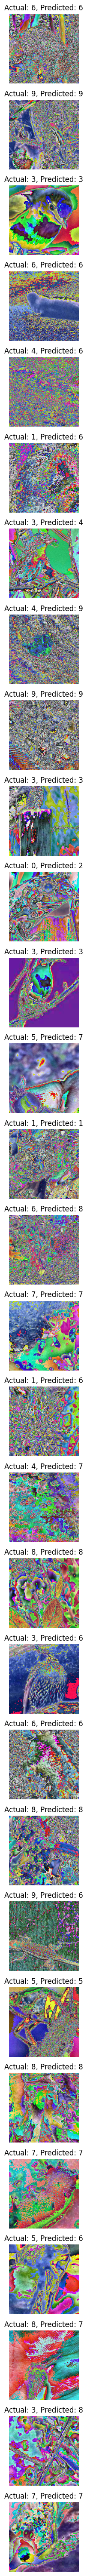

In [5]:
#Testing Dataset

def main():
    wandb.init(project='EE21S125_DL_A2');
    #Preprocessing Parameters
    # augument = wandb.config.data_augmentation;
    # num_dense_neurons = wandb.config.num_dense_neurons;
    # learning_rate = wandb.config.learning_rate;
    # dropout = wandb.config.dropout;
    # activation = wandb.config.activation;
    # num_filters = wandb.config.num_filters;
    # filter_organization = wandb.config.filter_organization;
    # batch_norm = wandb.config.batch_normalization;
    # num_epochs = wandb.config.num_epochs;
    # weight_decay = wandb.config.weight_decay;
    # optimizer = wandb.config.optimizer;

    augument = True;
    num_dense_neurons = 128;
    learning_rate = 0.0001;
    dropout = 0.2;
    activation = 'ReLU';
    num_filters = 32;
    filter_organization = 'same';
    batch_norm = True;
    num_epochs = 15;
    weight_decay = 0;
    optimizer = 'NAdam'


    dataset_directory = 'inaturalist_12K';
    image_size = 256;
    batch_size = 128;
    num_input = 3;
    num_output = 10;
    num_layers = 5;
    filter_size = 3;
    maxpool_size = 2;
    mode = 'test';

    wandb.run.name = ("Test_"+"Aug_"+str(augument)+
                      "_bn_"+str(batch_norm)+
                      "_fcn_"+str(num_dense_neurons)+
                      "_do_"+str(dropout)+
                      "_act_"+str(activation)+
                      "_nf_"+str(num_filters)+
                      "_fo_"+str(filter_organization)+
                      "_lr_"+str(learning_rate)
                      );

    training_set = PreProcessDataset(dataset_directory, image_size, mode, augument);
    train_size = int(0.8*len(training_set));
    validate_size = len(training_set) - train_size;
    train_dataset, validate_dataset = torch.utils.data.random_split(training_set, [train_size, validate_size]);
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0);
    validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=True, num_workers=0);

    mode = 'test';
    test_dataset = PreProcessDataset(dataset_directory, image_size, mode, augument);
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0);

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu');
    print("Device:", device);

    # Creating an instance of the model
    model = convolutionNN(image_size, num_input, num_output, filter_organization, batch_norm, num_layers, num_filters, filter_size, maxpool_size, dropout, activation, num_dense_neurons).to(device);

    criterion = torch.nn.CrossEntropyLoss();
    if optimizer == 'NAdam':
      optimizer=torch.optim.NAdam(model.parameters(),lr=learning_rate,weight_decay=weight_decay);
      anneal = CosineAnnealingLR(optimizer, T_max=num_epochs/2, eta_min = 0.0001);
    elif optimizer == 'SGD':
      optimizer=torch.optim.SGD(model.parameters(),lr=learning_rate,weight_decay=weight_decay);
      anneal = CosineAnnealingLR(optimizer, T_max=num_epochs/2, eta_min = 0.0001)

    validation_mode = 'train';
    for epoch in range(num_epochs):
      start_time = time.time();
      train_loss,train_accuracy = train(model,train_loader,optimizer,criterion,device);
      validate_loss,validate_accuracy = validate(model,validate_loader,criterion,device,validation_mode);
      anneal.step();
      end_time = time.time();
      elapsed_time = end_time - start_time;
      print("Epoch Time Taken:", elapsed_time);
      print("Training Accuracy:", train_accuracy," Training Loss:", train_loss, " Validation Accuracy:", validate_accuracy, " Validate Loss:", validate_loss," Epoch:", epoch +1);
      wandb.log({'train_loss': train_loss, 'train_accuracy':train_accuracy, 'validate_loss': validate_loss, 'validate_accuracy': validate_accuracy,'epoch':epoch + 1})
    validation_mode = 'test';
    test_loss,test_accuracy = validate(model,test_loader,criterion,device,validation_mode);
    print("Test Accuracy:", test_accuracy, " test Loss:", test_loss);
    wandb.log({'test_loss':test_loss,'test_accuracy':test_accuracy});
    wandb.finish();
    print("TESTING COMPLETE");




if __name__ == "__main__":
    sweep_config = {
                    'method': 'random',  # Choose 'grid', 'random', 'bayes', etc.
                    'metric': {
                                'name': 'validate_accuracy',
                                'goal': 'maximize'
                              },
                    'parameters': {
                        'num_filters': {'values': [32]},
                        'activation': {'values': ['ReLU']},
                        'filter_organization': {'values': ['same']},
                        'data_augmentation': {'values': [True]},
                        'batch_normalization': {'values': [True]},
                        'num_dense_neurons':{'values': [128]},
                        'dropout': {'values': [0.2]},
                        'learning_rate': {'values': [1e-4]},
                        'weight_decay': {'values': [0]},
                        'optimizer': {'values': ['NAdam']},
                        'num_epochs': {'values': [15]}

                    }
                  }
    sweep_id = wandb.sweep(sweep= sweep_config, project='EE21S125_DL_A2');
    wandb.agent(sweep_id, function = main,count=1);
    #main();
